# DQN flappy bird

In [1]:
import pygame
from pygame.locals import *  # noqa
import sys,os
import random
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import pygame.surfarray
import cv2
%matplotlib inline
# os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# flappy bird game
## pygame

In [2]:
class FlappyBird_GAME:
    
    def __init__(self):
        self.screen = pygame.display.set_mode((400, 700))
        self.bird = pygame.Rect(65, 50, 50, 50)
        self.background = pygame.image.load("assets/background.png").convert()
        self.birdSprites = [pygame.image.load("assets/1.png").convert_alpha(),
                            pygame.image.load("assets/2.png").convert_alpha(),
                            pygame.image.load("assets/dead.png")]
        self.wallUp = pygame.image.load("assets/bottom.png").convert_alpha()
        self.wallDown = pygame.image.load("assets/top.png").convert_alpha()
        self.distance = 0
        self.gap = 145
        self.wallx = 400
        self.birdY = 350
        self.jump = 11
        self.gravity = 6
        self.jumpSpeed = 9
        self.dead = False
        self.counter = 0
        self.offset = random.randint(-200, 200)
        self.sprite = 0
        self.image_data = None
        
    def calculateInput(self):
        dist_X_to_The_Wall = self.wallx+80
        dist_Y_to_The_Wall_UP = self.birdY-(0 - self.gap - self.offset+500)
        dist_Y_to_The_Wall_DOWN = self.birdY-(360 + self.gap - self.offset)
        dist_Y_TOP = self.birdY
        dist_Y_BOTTOM = 720-self.birdY
        res = [dist_X_to_The_Wall,dist_Y_to_The_Wall_UP,dist_Y_to_The_Wall_DOWN,dist_Y_TOP,dist_Y_BOTTOM]
        return res
    
    def reset(self):
        self.bird = pygame.Rect(65, 50, 50, 50)
        self.distance = 0
        self.gap = 145
        self.wallx = 400
        self.birdY = 350
        self.jump = 0
        self.gravity = 6
        self.jumpSpeed = 9
        self.dead = False
        self.counter = 0
        self.offset = random.randint(-200, 200)
        self.sprite = 0
        self.image_data = None
        return np.array(self.calculateInput())
    
    def isDead(self):
        return self.dead
    
    def TotalDistance(self):
        return self.distance

    def centerWalls(self):
        return 0 - self.gap - self.offset+572.5
    
    def downWall(self):
        return 360 + self.gap - self.offset
    
    def posBird(self):
        return self.birdY
    
    def updateWalls(self):
        self.wallx -= 4
        if self.wallx < -80:
            self.wallx = 400
            self.counter += 1
            self.offset = random.randint(-200, 200)

    def birdUpdate(self):
        self.distance =  self.distance + 1 
        if self.jump:
            self.jumpSpeed -= 1
            self.birdY -= self.jumpSpeed
            self.jump -= 1
        else:
            self.birdY += self.gravity
            self.gravity += 0.2
        self.bird[1] = self.birdY
        upRect = pygame.Rect(self.wallx,
                             360 + self.gap - self.offset + 10,
                             88,
                             500)
        downRect = pygame.Rect(self.wallx,
                               0 - self.gap - self.offset - 10,
                               88,
                               500)
        if upRect.colliderect(self.bird):
            self.dead = True
        if downRect.colliderect(self.bird):
            self.dead = True
        if not 0 < self.bird[1] < 720:
            self.dead=True
            
        

    def step(self,jump,epi):
        if (jump==True) and not self.dead:
            self.jump = 10
            self.gravity = 6
            self.jumpSpeed = 8
        self.updateWalls()
        self.birdUpdate()
        
        self.screen.fill((0,0,0))
        self.screen.blit(self.background, (0, 0))
        self.screen.blit(self.wallUp,(self.wallx, 360 + self.gap - self.offset))
        self.screen.blit(self.wallDown,(self.wallx, 0 - self.gap - self.offset))
        self.screen.blit(font.render(str(self.counter),-1,(255, 255, 255)),(370, 20))
        self.screen.blit(font.render('ep:'+str(epi),-1,(255, 255, 255)),(20, 20))
        if self.dead:
            self.sprite = 2
        elif self.jump:
            self.sprite = 1
        self.screen.blit(self.birdSprites[self.sprite], (70, self.birdY))
        if not self.dead:
            self.sprite = 0
        pygame.display.update()
        
        #get image
        img = pygame.surfarray.array3d(pygame.display.get_surface())
        self.image_data = img.swapaxes(1,0)
        
        #[dist_X_to_The_Wall, Y_to_The_Wall_UP, Y_to_The_Wall_DOWN, Y_TOP, Y_BOTTOM]
        observation = np.array(self.calculateInput())
        info = {}
        done = self.dead
        
        
#         reward = abs(1.0/(observation[1]+observation[2]+1e-2)) * 100 # +1e-2 prevent devision by 0
        reward = (700 - abs(observation[1]+observation[2]))/70.0
        reward += 0 if observation[0] > 2 else 10

        if done : reward = -10
        
        return observation, reward, done, info

# DQN tensorflow
### hyper parameter:
    learning rate: 0.05
    gamma: 0.9
    memory size: 500
    epislon greedy: 0.95
    replace target iteratino: 100

In [3]:
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.95,
            replace_target_iter=200,
            memory_size=500,
            batch_size=64,
            e_greedy_increment=None,
            output_graph=True,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 20, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, n_l1], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, n_l1], initializer=b_initializer, collections=c_names)
                l2 = tf.nn.relu(tf.matmul(l1, w2) + b2)
           
            with tf.variable_scope('l3'):
                w3 = tf.get_variable('w3', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b3 = tf.get_variable('b3', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l2, w3) + b3


        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, n_l1], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, n_l1], initializer=b_initializer, collections=c_names)
                l2 = tf.nn.relu(tf.matmul(l1, w2) + b2)
                
            with tf.variable_scope('l3'):
                w3 = tf.get_variable('w3', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b3 = tf.get_variable('b3', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l2, w3) + b3

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

# connect game with DQN & start training

### action flap[2]    :  [true, false]
### observation[5]  :  [dist_X_to_The_Wall,  Y_to_The_Wall_UP,  Y_to_The_Wall_DOWN,  Y_TOP,  Y_BOTTOM]

In [4]:
game = FlappyBird_GAME()
clock = pygame.time.Clock()
pygame.font.init()
font = pygame.font.SysFont("Arial", 50)

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')    
video = cv2.VideoWriter("flappy.mp4",fourcc, 60,(400,700))
frame_rate = 60 #fps

action_set = [True,False]
RL = DeepQNetwork(n_actions=2, n_features=game.reset().shape[0])

max_episode = 200
step = 0
for episode in range(max_episode):
    print("episode",episode)
    observation = game.reset()
    while True:
        
#         clock.tick(frame_rate) 
        
        action = RL.choose_action(observation)
        
        observation_,reward,done,info = game.step(action_set[action],episode)
        RL.store_transition(observation, action, reward, observation_)
        
        if (step > 80): RL.learn()
        observation = observation_
        if done : break
        step += 1
        video.write(cv2.cvtColor(game.image_data,cv2.COLOR_BGR2RGB))
        
video.release()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
episode 0
episode 1

target_params_replaced

episode 2

target_params_replaced

episode 3
episode 4

target_params_replaced

episode 5
episode 6
episode 7

target_params_replaced

episode 8
episode 9

target_params_replaced

episode 10

target_params_replaced

episode 11
episode 12

target_params_replaced

episode 13
episode 14
episode 15

target_params_replaced

episode 16
episode 17
episode 18

target_params_replaced

episode 19
episode 20
episode 21

target_params_replaced

episode 22
episode 23
episode 24

target_params_replaced

episode 25
episode 26
episode 27

target_params_replaced

episode 28
episode 29

target_params_replaced

episode 30
episode 31

target_params_replaced

episode 32
episode 33
episode 34

target_params_replaced

episode 35

target_params_replaced

episode 36
episode 37

target_params_replaced

episode 38
episode 39
episode 40

target_params_r

# checkout your VNC
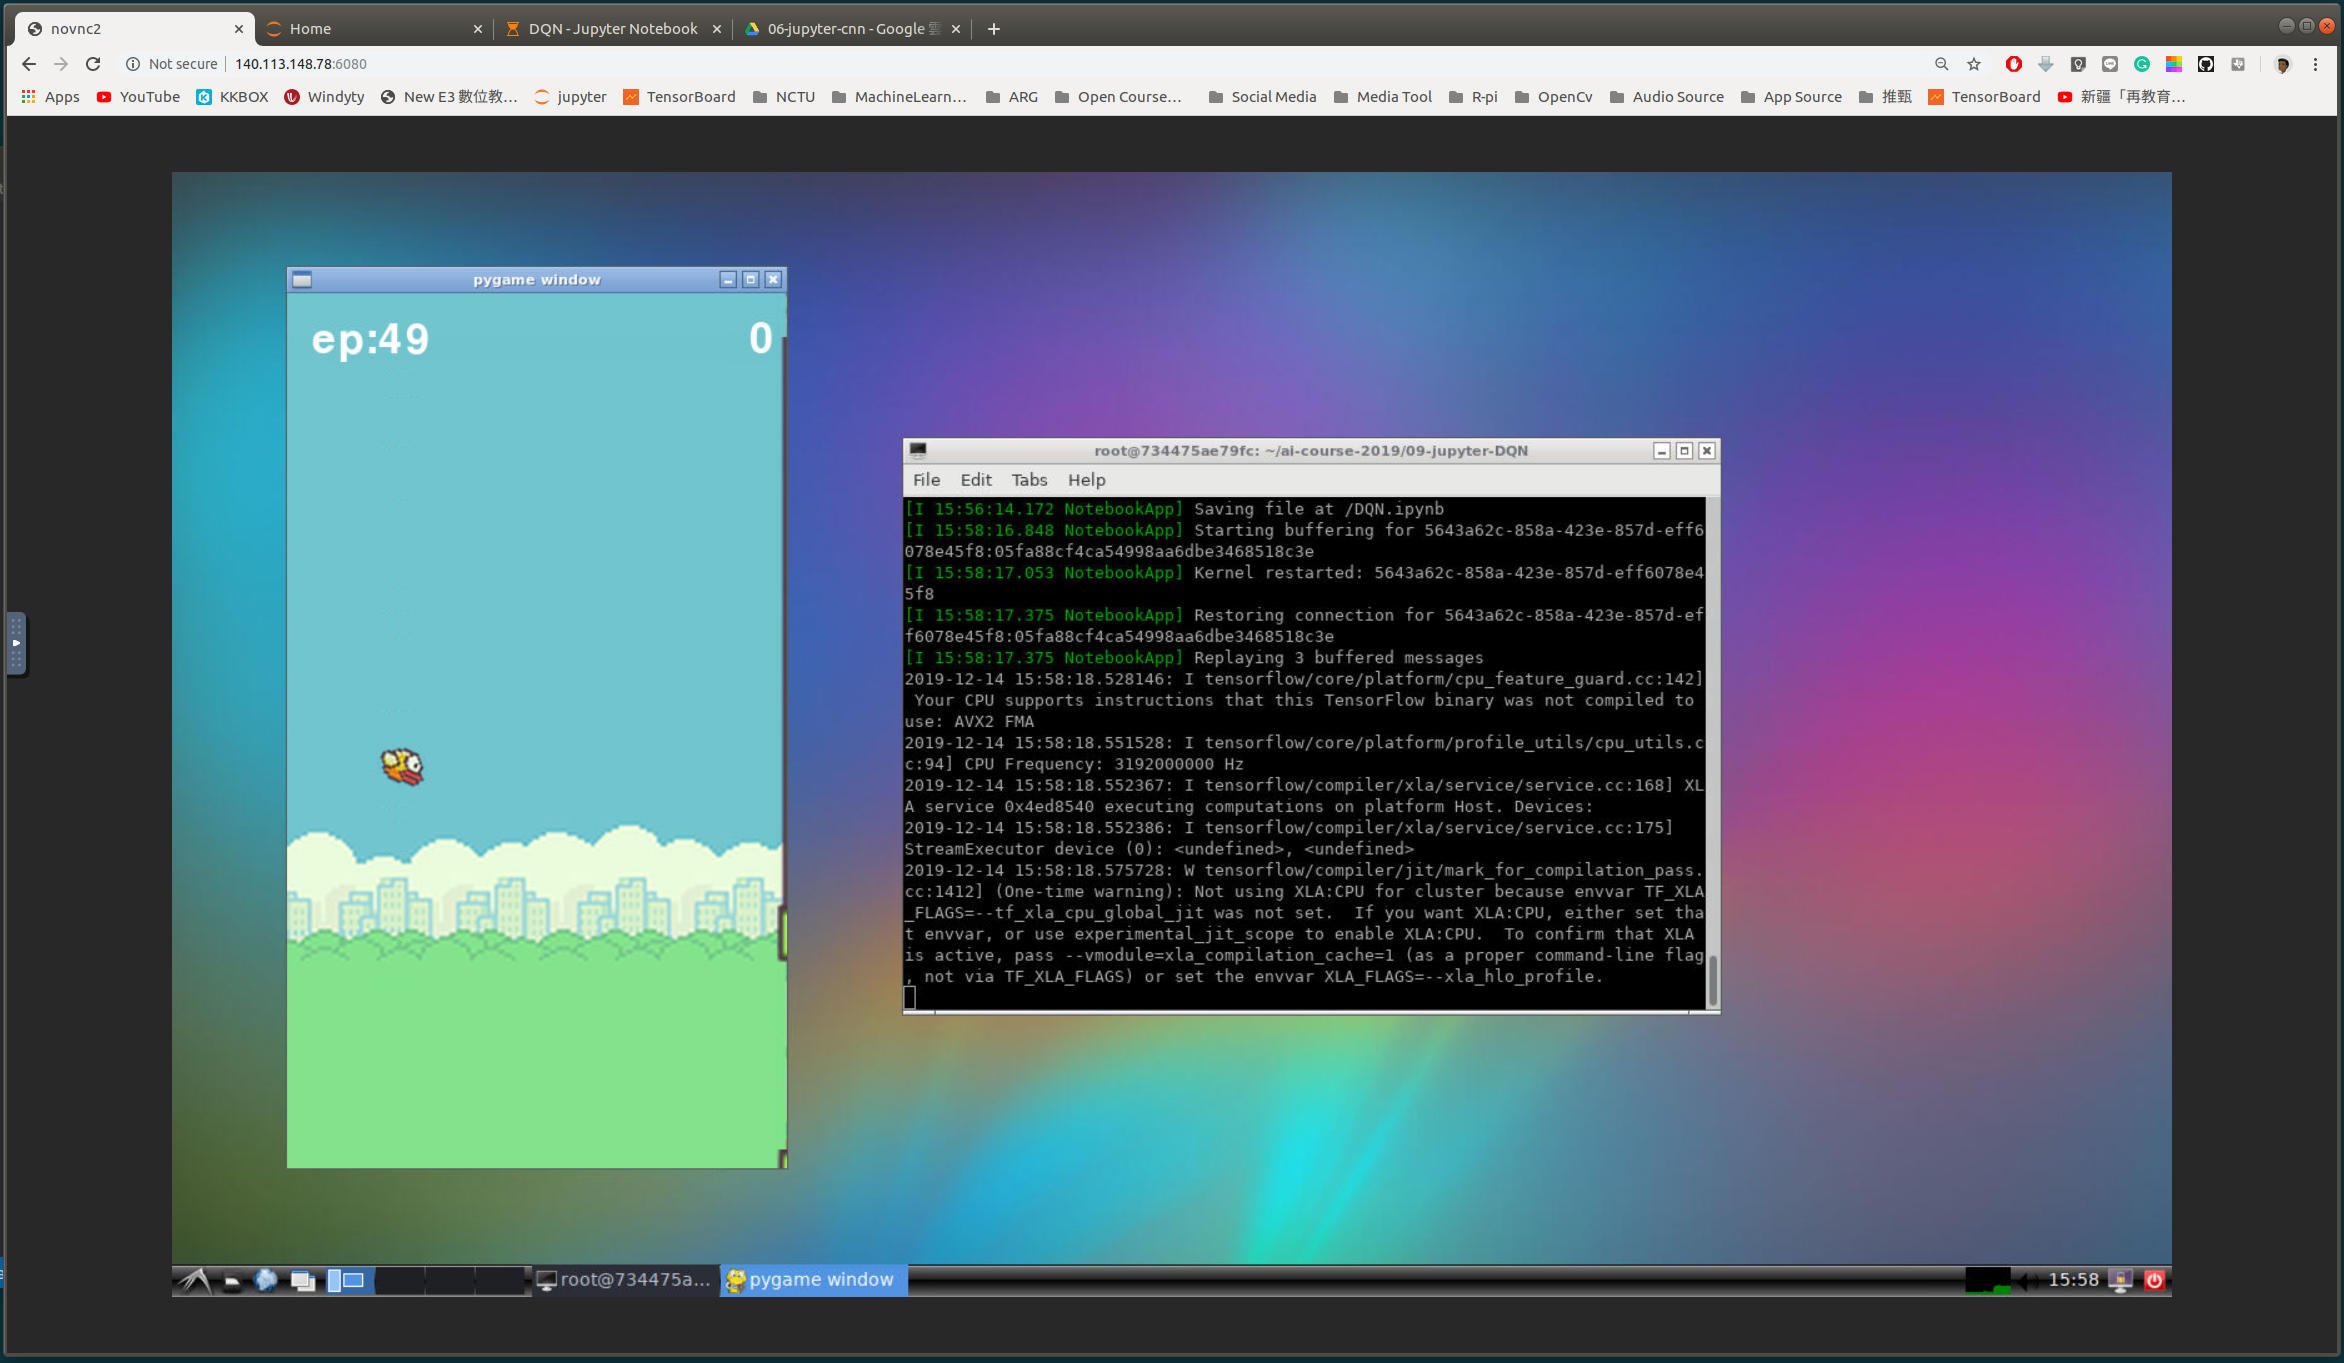